# Imports

In [ ]:
!pip install scikit-learn-extra

     |████████████████████████████████| 624kB 5.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-learn-extra: filename=scikit_learn_extra-0.1.0b2-cp37-cp37m-linux_x86_64.whl size=339929 sha256=f7bcbb62507504f7c2bfb48d2847224cf34d6b285982be43215c67287f4380ee
  Stored in directory: /root/.cache/pip/wheels/04/01/0f/943bffb48bac048fa216b4325f1a6c939491ccb0ff500e08f4
Successfully built scikit-learn-extra


In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import random
import shutil
import time
from sklearn.metrics.pairwise import rbf_kernel
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process.kernels import RBF
import torch
from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
import torch.optim as optim
from __future__ import print_function
from sklearn_extra.cluster import KMedoids
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cpu


# Cifar

## Get superclasses

In [ ]:
class CIFAR10(data.Dataset):
    """`CIFAR10 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    Args:
        root (string): Root directory of dataset where directory
            ``cifar-10-batches-py`` exists.
        train (bool, optional): If True, creates dataset from training set, otherwise
            creates from test set.
        transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.
    """
    base_folder = 'cifar-10-batches-py'
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    filename = "cifar-10-python.tar.gz"
    tgz_md5 = 'c58f30108f718f92721af3b95e74349a'
    train_list = [
        ['data_batch_1', 'c99cafc152244af753f735de768cd75f'],
        ['data_batch_2', 'd4bba439e000b95fd0a9bffe97cbabec'],
        ['data_batch_3', '54ebc095f3ab1f0389bbae665268c751'],
        ['data_batch_4', '634d18415352ddfa80567beed471001a'],
        ['data_batch_5', '482c414d41f54cd18b22e5b47cb7c3cb'],
    ]

    test_list = [
        ['test_batch', '40351d587109b95175f43aff81a1287e'],
    ]


    def __init__(self, root="/", train=True,
                 transform=None, target_transform=None,
                 download=True, coarse=True):
        self.root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform
        self.train = train  # training set or test set
        self.coarse = coarse

        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You can use download=True to download it')

        # now load the picked numpy arrays
        if self.train:
            self.train_data = []
            self.train_labels = []
            self.train_coarse_labels = []
            for fentry in self.train_list:
                f = fentry[0]
                file = os.path.join(self.root, self.base_folder, f)
                fo = open(file, 'rb')
                if sys.version_info[0] == 2:
                    entry = pickle.load(fo)
                else:
                    entry = pickle.load(fo, encoding='latin1')
                self.train_data.append(entry['data'])
                if 'labels' in entry:
                    self.train_labels += entry['labels']
                else:
                    self.train_labels += entry['fine_labels']
                    if self.coarse:
                        self.train_coarse_labels += entry['coarse_labels']
                fo.close()

            self.train_data = np.concatenate(self.train_data)
            self.train_data = self.train_data.reshape((50000, 3, 32, 32))
            self.train_data = self.train_data.transpose((0, 2, 3, 1))  # convert to HWC
        else:
            f = self.test_list[0][0]
            file = os.path.join(self.root, self.base_folder, f)
            fo = open(file, 'rb')
            if sys.version_info[0] == 2:
                entry = pickle.load(fo)
            else:
                entry = pickle.load(fo, encoding='latin1')
            self.test_data = entry['data']
            if 'labels' in entry:
                self.test_labels = entry['labels']
            else:
                self.test_labels = entry['fine_labels']
                if self.coarse:
                    self.test_coarse_labels = entry['coarse_labels']
            fo.close()
            self.test_data = self.test_data.reshape((10000, 3, 32, 32))
            self.test_data = self.test_data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
            if self.coarse:
                coarse_target = self.train_coarse_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]
            if self.coarse:
                coarse_target = self.test_coarse_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)
        if not self.coarse:
            return img, target
        else:
            return img, target, coarse_target

    def __len__(self):
        if self.train:
            return len(self.train_data)
        else:
            return len(self.test_data)

    def _check_integrity(self):
        root = self.root
        for fentry in (self.train_list + self.test_list):
            filename, md5 = fentry[0], fentry[1]
            fpath = os.path.join(root, self.base_folder, filename)
            if not check_integrity(fpath, md5):
                return False
        return True

    def download(self):
        import tarfile

        if self._check_integrity():
            print('Files already downloaded and verified')
            return

        root = self.root
        download_url(self.url, root, self.filename, self.tgz_md5)

        # extract file
        cwd = os.getcwd()
        tar = tarfile.open(os.path.join(root, self.filename), "r:gz")
        os.chdir(root)
        tar.extractall()
        tar.close()
        os.chdir(cwd)


class CIFAR100(CIFAR10):
    """`CIFAR100 <https://www.cs.toronto.edu/~kriz/cifar.html>`_ Dataset.
    This is a subclass of the `CIFAR10` Dataset.
    """
    base_folder = 'cifar-100-python'
    url = "https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz"
    filename = "cifar-100-python.tar.gz"
    tgz_md5 = 'eb9058c3a382ffc7106e4002c42a8d85'
    train_list = [
        ['train', '16019d7e3df5f24257cddd939b257f8d'],
    ]

    test_list = [
        ['test', 'f0ef6b0ae62326f3e7ffdfab6717acfc'],
    ]

In [ ]:
c = CIFAR100()
imgs = []
ts = []
cts = []
for indx, (img, t, ct) in enumerate(c):
    ts.append(t)
    cts.append(ct)
map_superclass = {}
for i in range(len(ts)):
    if ts[i] not in map_superclass:
        map_superclass[ts[i]] = cts[i]

In [ ]:
map_superclass

{0: 4,
 1: 1,
 2: 14,
 3: 8,
 4: 0,
 5: 6,
 6: 7,
 7: 7,
 8: 18,
 9: 3,
 10: 3,
 11: 14,
 12: 9,
 13: 18,
 14: 7,
 15: 11,
 16: 3,
 17: 9,
 18: 7,
 19: 11,
 20: 6,
 21: 11,
 22: 5,
 23: 10,
 24: 7,
 25: 6,
 26: 13,
 27: 15,
 28: 3,
 29: 15,
 30: 0,
 31: 11,
 32: 1,
 33: 10,
 34: 12,
 35: 14,
 36: 16,
 37: 9,
 38: 11,
 39: 5,
 40: 5,
 41: 19,
 42: 8,
 43: 8,
 44: 15,
 45: 13,
 46: 14,
 47: 17,
 48: 18,
 49: 10,
 50: 16,
 51: 4,
 52: 17,
 53: 4,
 54: 2,
 55: 0,
 56: 17,
 57: 4,
 58: 18,
 59: 17,
 60: 10,
 61: 3,
 62: 2,
 63: 12,
 64: 12,
 65: 16,
 66: 12,
 67: 1,
 68: 9,
 69: 19,
 70: 2,
 71: 10,
 72: 0,
 73: 1,
 74: 16,
 75: 12,
 76: 9,
 77: 13,
 78: 15,
 79: 13,
 80: 16,
 81: 19,
 82: 2,
 83: 4,
 84: 6,
 85: 19,
 86: 5,
 87: 5,
 88: 8,
 89: 19,
 90: 18,
 91: 1,
 92: 2,
 93: 15,
 94: 6,
 95: 0,
 96: 17,
 97: 8,
 98: 14,
 99: 13}

## Network

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                                                                padding=0, bias=False) or None
    def forward(self, x):
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)


class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]
        assert ((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]
        self.softmax = nn.Softmax(dim = 1)
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out_fc = out.view(-1, self.nChannels)
        out = self.fc(out_fc)
        out = self.softmax(out)
        return out, out_fc

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def metrics_print(net, expert_fn, n_classes, loader):
    '''
    Computes metrics for deferal
    -----
    Arguments:
    net: model
    expert_fn: expert model predict function
    n_classes: number of classes
    loader: data loader
    '''
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            batch_size = outputs.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels)
            for i in range(0, batch_size):
                r = (predicted[i].item() == n_classes)
                if r == 0:
                    total += 1
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    exp_total += 1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    print(to_print)

In [ ]:
def my_CrossEntropyLoss(outputs, labels):
    batch_size = outputs.size()[0]  # batch_size
    outputs = - torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
    return torch.sum(outputs) / batch_size

def train_classifier(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_classes):
    """Train for one epoch on the training set"""
    # expertfn: a number here k 
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.to(device)
        # map to superclass for cifar100
        for k in range(len(target)):
            target[k] = map_superclass[target[k].cpu().item()]
        input = input.to(device)

        # compute output
        output, _ = model(input)
        # compute loss
        loss = my_CrossEntropyLoss(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                epoch, i, len(train_loader), batch_time=batch_time,
                loss=losses, top1=top1))


def validate_classifier(val_loader, model, epoch, expert_fn, n_classes):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.to(device)
        input = input.to(device)
        # map to superclass for cifar100
        for k in range(len(target)):
            target[k] = map_superclass[target[k].cpu().item()]
        # compute output
        with torch.no_grad():
            output, _ = model(input)
        # compute loss
        loss = my_CrossEntropyLoss(output, target)

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                i, len(val_loader), batch_time=batch_time, loss=losses,
                top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'.format(top1=top1))

    return top1.avg
best_prec1 = 0
def run_classifier(model, data_aug, n_dataset, expert_fn, epochs):
    global best_prec1
    # Data loading code
    normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                     std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

    if data_aug:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                              (4, 4, 4, 4), mode='reflect').squeeze()),
            transforms.ToPILImage(),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    if n_dataset == 10:
        dataset = 'cifar10'
    elif n_dataset == 100:
        dataset = 'cifar100'

    kwargs = {'num_workers': 0, 'pin_memory': True}

    train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=True, download=True,
                                                           transform=transform_train)
    train_size = int(0.90 * len(train_dataset_all))
    test_size = len(train_dataset_all) - train_size

    train_dataset, test_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size])
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=128, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=128, shuffle=True, **kwargs)

    # get the number of model parameters
    print('Number of model parameters: {}'.format(
        sum([p.data.nelement() for p in model.parameters()])))

    # for training on multiple GPUs.
    # Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
    # model = torch.nn.DataParallel(model).cuda()
    model = model.to(device)

    # optionally resume from a checkpoint

    cudnn.benchmark = True

    # define loss function (criterion) and optimizer
    optimizer = torch.optim.SGD(model.parameters(), 0.1,
                                momentum=0.9, nesterov=True,
                                weight_decay=5e-4)

    # cosine learning rate
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader) * 200)

    for epoch in range(0, epochs):
        # train for one epoch
        train_classifier(train_loader, model, optimizer, scheduler, epoch, expert_fn, n_dataset)

In [ ]:
n_dataset = 100  # cifar-10, 100 for cifar-100
model_classifier = WideResNet(10, 20, 1, dropRate=0)

In [ ]:
run_classifier(model_classifier, False, n_dataset, 0, 200)


In [ ]:
#torch.save(model_classifier, "./model_base")
#model_classifier = torch.load("./model_base100")
#model_classifier.eval()
#model_classifier.to(device)


## Collect dataset of image, label, prediction



In [ ]:

best_prec1 = 0
global best_prec1
# Data loading code
normalize = transforms.Normalize(mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
                                    std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

if False:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: F.pad(x.unsqueeze(0),
                                            (4, 4, 4, 4), mode='reflect').squeeze()),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

if n_dataset == 10:
    dataset = 'cifar10'
elif n_dataset == 100:
    dataset = 'cifar100'

kwargs = {'num_workers': 0, 'pin_memory': True}

train_dataset_all = datasets.__dict__[dataset.upper()]('../data', train=False, download=True,
                                                        transform=transform_train)
train_size = int(0.5 * len(train_dataset_all))
test_size = len(train_dataset_all) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(train_dataset_all, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=128, shuffle=False, **kwargs)

# get the number of model parameters
print('Number of model parameters: {}'.format(
    sum([p.data.nelement() for p in model_classifier.parameters()])))

# for training on multiple GPUs.
# Use CUDA_VISIBLE_DEVICES=0,1 to specify which GPUs to use
# model = torch.nn.DataParallel(model).cuda()
model_classifier = model_classifier.to(device)

# optionally resume from a checkpoint

cudnn.benchmark = True





NameError: ignored

In [ ]:

images = []
targets = []
preds = []
representations = []


# switch to evaluate mode
model_classifier.eval()

end = time.time()
for i, (input, target) in enumerate(train_loader):
    target = target.to(device)
    input = input.to(device)
    # map to superclass for cifar100
    for k in range(len(target)):
        target[k] = map_superclass[target[k].cpu().item()]
    # compute output
    with torch.no_grad():
        output, repr = model_classifier(input)
    images.append(input)
    targets.append(target)
    preds.append(output)
    representations.append(repr)

repr_cpu = []
for i in range(len(representations)):
    for j in range(len(representations[i])):
        repr_cpu.append(representations[i][j].cpu().numpy())
repr_cpu = np.array(repr_cpu)

targets_cpu = []
for i in range(len(targets)):
    for j in range(len(targets[i])):
        targets_cpu.append(targets[i][j].cpu().numpy())
targets_cpu = np.array(targets_cpu)

Do PCA

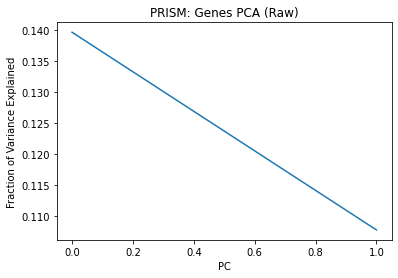

In [ ]:
# need to do data spliting

scaler = StandardScaler()
scaled_repr = scaler.fit_transform(repr_cpu)
n_components = 2
pca = PCA(n_components=n_components)
pca.fit(scaled_repr)
plt.plot(np.arange(n_components),pca.explained_variance_ratio_);
plt.title('PRISM: Genes PCA (Raw)')
plt.xlabel('PC')
plt.ylabel('Fraction of Variance Explained')

train_pca = pca.transform(repr_cpu)


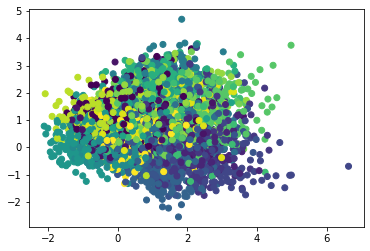

In [ ]:
plt.scatter(train_pca[:,0],train_pca[:,1], c = targets_cpu)

In [ ]:
expert_k = 10
n_classes = 20
machine_exp = synth_expert(expert_k, n_classes)

In [ ]:
class synth_expert:
    def __init__(self, k, n_classes):
        self.k = k
        self.n_classes = n_classes

    def predict(self, input, labels):
        batch_size = labels.size()[0]  # batch_size
        outs = [0] * batch_size
        for i in range(0, batch_size):
            if labels[i].item() <= self.k:
                outs[i] = labels[i].item()
            else:
                prediction_rand = random.randint(0, self.n_classes - 1)
                outs[i] = prediction_rand
        return outs


In [ ]:
def metrics_prior(net_class, expert_fn, n_classes, loader):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    predictions = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            for k in range(len(labels)):
                labels[k] = map_superclass[labels[k].cpu().item()]
            outputs_class, _ = net_class(images)
            confidences, predicted = torch.max(outputs_class.data, 1)
            batch_size = outputs_class.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels) # exp is AI
            for i in range(0, batch_size):
                if confidences[i] >= 0.65:
                    r = 0
                else:
                    r = 1
                if r == 0:
                    total += 1
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                    predictions.append((predicted[i] == labels[i]).item())
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    predictions.append((exp_prediction[i] == labels[i].item()))
                    exp_total += 1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    print(to_print)
    return predictions

In [ ]:
preds = metrics_prior(model_classifier, machine_exp.predict,20, train_loader )

{'coverage': '2199 out of5000', 'system accuracy': 64.22, 'expert accuracy': 53.40949279475239, 'classifier accuracy': 77.98999190586666}


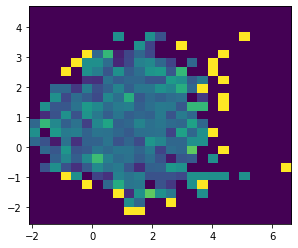

In [ ]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data

heatmap, xedges, yedges = np.histogram2d(train_pca[:,0],train_pca[:,1], weights=preds, bins=25)
heatmap_total, xedges, yedges = np.histogram2d(train_pca[:,0],train_pca[:,1],  bins=25)

extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
errors = 1- (heatmap + 0.00001)/(heatmap_total+0.00001)
plt.imshow(errors.T, extent=extent, origin='lower')
plt.show()

In [ ]:
class human_learner_knn:
    def __init__(self, gamma):
        self.gamma = gamma
        self.teaching_set = []
        self.kernel_raw = RBF()

    def kernel(self, x,y):
        kernel_computation = self.kernel_raw(x.reshape(1,-1),y.reshape(1,-1))[0][0]
        return kernel_computation

    def predict(self, x):
        ball_at_x = []
        for i in range(len(self.teaching_set)):
            similarity = np.linalg.norm(x-self.teaching_set[i][0])
            if similarity <= self.gamma:
                ball_at_x.append(self.teaching_set[i])
        if len(ball_at_x) == 0:
            return -1
        normalization = np.sum([self.kernel(x,ball_at_x[i][0]) for i in range(len(ball_at_x))])
        score_one = np.sum([self.kernel(x,ball_at_x[i][0])*ball_at_x[i][1] for i in range(len(ball_at_x))])
        pred = score_one / normalization
        if pred >= 0.5:
            return 1
        else:
            return 0

    def add_to_teaching(self, exam):
        self.teaching_set.append(exam)

    def remove_teaching(self):
        self.teaching_set = self.teaching_set[:-1]

In [ ]:
def metrics_posterior(net_class, posterior_knn, epsilon, expert_fn, n_classes, loader):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    predictions = []
    indx = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            for k in range(len(labels)):
                labels[k] = map_superclass[labels[k].cpu().item()]
            outputs_class, outputs_repr = net_class(images)
            confidences, predicted = torch.max(outputs_class.data, 1)
            batch_size = outputs_class.size()[0]  # batch_size
            exp_prediction = expert_fn(images, labels) # exp is AI
            for i in range(0, batch_size):
                im_repr = outputs_repr[i].cpu().numpy()
                im_repr = pca.transform([im_repr])[0] 
                post_pred = posterior_knn.predict(im_repr)
                
                if post_pred == -1:
                    if confidences[i] >= epsilon:
                        r = 0
                    else:
                        r = 1
                else:
                    r = post_pred
                if r == 0:
                    total += 1
                    correct += (predicted[i] == labels[i]).item()
                    correct_sys += (predicted[i] == labels[i]).item()
                    predictions.append((predicted[i] == labels[i]).item())
                if r == 1:
                    exp += (exp_prediction[i] == labels[i].item())
                    correct_sys += (exp_prediction[i] == labels[i].item())
                    predictions.append((exp_prediction[i] == labels[i].item()))
                    exp_total += 1
                real_total += 1
                indx += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print = {"coverage": cov, "system accuracy": 100 * correct_sys / real_total,
                "expert accuracy": 100 * exp / (exp_total + 0.0002),
                "classifier accuracy": 100 * correct / (total + 0.0001)}
    
    print(to_print)
    return predictions, to_print

In [ ]:
knn_hum  = human_learner_knn(1)
#knn_hum.add_to_teaching((pca_repr[0],1))

In [ ]:
preds = metrics_posterior(model_classifier,knn_hum, 0.7, machine_exp.predict,20,test_loader )

{'coverage': '1971 out of5000', 'system accuracy': 62.64, 'expert accuracy': 50.7098018679563, 'classifier accuracy': 80.97412070146521}


do greedy strategey with fixed gamma and metric is accuracy on train 

In [ ]:
MAX_TRIALS = 5
RESOLUTION = 1
MAX_SIZE = 30

In [ ]:
data_sizes  = []
indices_used = []
test_errors = [[] for _ in range(MAX_TRIALS)]
for trial in range(MAX_TRIALS):
    for itt in range(10):
        best_index = -1
        best_value = 0
        if itt % RESOLUTION == 0:
            print("evaluating at size " + str(itt) )
            preds, metrics = metrics_posterior(model_classifier,knn_hum, 0.7, machine_exp.predict,20, test_loader)
            test_errors[trial].append(metrics["system accuracy"])
            data_sizes.append(itt)

        valid_indices = list(set(list(range(len(train_pca)))) - set(indices_used))
        subset_size = 100
        random_teach_subset = random.sample(valid_indices, subset_size) # used to take gradient steps
        print("")
        # for each point, add and see effect then remove
        for j in random_teach_subset:
            repr_x = train_pca[j]
            target = targets_cpu[j]
            correct_deferal = 1 if target <= 10 else 0
            knn_hum.add_to_teaching((repr_x, correct_deferal))
            preds, metrics = metrics_posterior(model_classifier, knn_hum, 0.7, machine_exp.predict, 20, train_loader)
            acc = metrics["system accuracy"]
            if acc >= best_value:
                best_value = acc
                best_index = j
            knn_hum.remove_teaching()
        indices_used.append(best_index) # add found element to set used
        repr_x = train_pca[best_index]
        target = targets_cpu[best_index]    
        correct_deferal = 1 if target <= 10 else 0
        knn_hum.add_to_teaching((repr_x, correct_deferal))


evaluating at size 0
{'coverage': '1164 out of5000', 'system accuracy': 62.6, 'expert accuracy': 57.716368210825436, 'classifier accuracy': 78.69415131493545}

{'coverage': '1093 out of5000', 'system accuracy': 65.14, 'expert accuracy': 61.32582230223587, 'classifier accuracy': 78.77400926129833}
{'coverage': '767 out of5000', 'system accuracy': 62.8, 'expert accuracy': 59.2487569454875, 'classifier accuracy': 82.3989462322104}
{'coverage': '1041 out of5000', 'system accuracy': 64.86, 'expert accuracy': 61.17706182485164, 'classifier accuracy': 78.86646696767849}
{'coverage': '1471 out of5000', 'system accuracy': 64.5, 'expert accuracy': 62.17058304502221, 'classifier accuracy': 70.08837049025354}
{'coverage': '1505 out of5000', 'system accuracy': 64.92, 'expert accuracy': 62.57510371530165, 'classifier accuracy': 70.36544382953862}
{'coverage': '1783 out of5000', 'system accuracy': 62.58, 'expert accuracy': 62.20080433939668, 'classifier accuracy': 63.2641579773327}
{'coverage': '1255

# Guassian mixture

In [ ]:
def sample(mu, var, nb_samples=500):
    """
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

    
class Linear_net_sig(nn.Module):
    def __init__(self, input_dim):
        super(Linear_net_sig, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

def run_classifier_sig(net, data_x, data_y, n_epochs = 10000):
    BCE = torch.nn.BCELoss(size_average=True)
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000*10000)
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
        inputs = data_x
        labels = data_y
        order = np.array(range(len(data_x)))
        np.random.shuffle(order)
        # in-place changing of values
        inputs[np.array(range(len(data_x)))] = inputs[order]
        labels[np.array(range(len(data_x)))] = labels[order]
        # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)[:,0]

        loss = BCE(outputs, labels*1.0) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        running_loss += loss.item()
        if epoch % 10000 == 0:
            print("loss " + str(loss.item()))

    #print('Finished Training')


def test_classifier_sig(net, data_x, data_y):
    correct = 0
    total = 0
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        outputs = net(inputs)
        predicted = torch.round(outputs.data)
        total = labels.size(0)
        for i in range(total):
            correct += predicted[i].item() == labels[i].item()
        #correct = (predicted == labels).sum()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [ ]:
class human_learner_knn:
    def __init__(self):
        self.teaching_set = []
        self.kernel_raw = RBF()

    def kernel(self, x,y):
        kernel_computation = self.kernel_raw(x.reshape(1,-1),y.reshape(1,-1))[0][0]
        return kernel_computation

    def predict(self, xs):
        '''
        x: expected array of inputs
        '''
        preds = []
        for x in xs:
            ball_at_x = []
            if len(self.teaching_set) == 0:
                preds.append(-1)
                continue
            similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
            for i in range(len(self.teaching_set)):

                similarity = similarities[i]
                if similarity >= self.teaching_set[i][2]:
                    ball_at_x.append(self.teaching_set[i])
            if len(ball_at_x) == 0:
                preds.append(-1)
                continue
            ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
            normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
            score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
            pred = score_one / normalization
            if pred >= 0.5:
                preds.append(1)
            else:
                preds.append(0)
        return preds

    def add_to_teaching(self, exam):
        self.teaching_set.append(exam)

    def remove_teaching(self):
        self.teaching_set = self.teaching_set[:-1]

In [ ]:

def test_prior(net_hum, net_mach, epsilon, data_x, data_y):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        m = net_mach(inputs)
        predicted_exp = torch.round(m.data)
        outputs = net_hum(inputs)
        predicted = torch.round(outputs.data)
        for i in range(len(inputs)):
            r_score = max(1 - outputs.data[i].item(), outputs.data[i].item())
            r = 0
            if r_score <  epsilon:
                r = 1
            else:
                r =  0
            if r == 1:
                exp += (predicted_exp[i] == labels[i]).item()
                correct_sys += (predicted_exp[i] == labels[i]).item()
                exp_total += 1
            elif r == 0:
                correct += (predicted[i] == labels[i]).item() 
                correct_sys += (predicted[i] == labels[i]).item()
                total += 1
        real_total += labels.size(0)
    cov = str(total) + str(" out of") + str(real_total)
    to_print={"coverage":cov, "system accuracy": 100*correct_sys/real_total, "expert accuracy":100* exp/(exp_total+0.0002),"classifier accuracy":100*correct/(total+0.0001), "alone classifier": 100*alone_correct/real_total }
    #print(to_print)
    return to_print

In [ ]:

def test_posterior(net_hum, net_mach, epsilon, knn_learner, data_x, data_y):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    mistakes = []
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        m = net_mach(inputs)
        predicted_exp = torch.round(m.data)
        outputs = net_hum(inputs)
        predicted = torch.round(outputs.data)
        post_preds = knn_learner.predict(inputs.numpy())
        for i in range(len(inputs)):
            r = post_preds[i]
            if r == -1: # if no point in  ball
                r_score = max(1 - outputs.data[i].item(), outputs.data[i].item())
                if r_score <  epsilon:
                    r = 1
                else:
                    r =  0
            if r == 1:
                exp += (predicted_exp[i] == labels[i]).item()
                correct_sys += (predicted_exp[i] == labels[i]).item()
                mistakes.append((predicted_exp[i] == labels[i]).item()*1.0)
                exp_total += 1
            elif r == 0:
                correct += (predicted[i] == labels[i]).item() 
                correct_sys += (predicted[i] == labels[i]).item()
                mistakes.append((predicted[i] == labels[i]).item()*1.0)
                total += 1
        real_total += labels.size(0)
    cov = str(total) + str(" out of") + str(real_total)
    to_print={"coverage":cov, "system accuracy": 100*correct_sys/real_total, "expert accuracy":100* exp/(exp_total+0.0002),"classifier accuracy":100*correct/(total+0.0001), "alone classifier": 100*alone_correct/real_total }
    #print(to_print)
    return mistakes, to_print

In [ ]:
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

In [ ]:
'''
seed = 442
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)
'''

"\nseed = 442\nos.environ['PYTHONHASHSEED'] = str(seed)\n# Torch RNG\ntorch.manual_seed(seed)\ntorch.cuda.manual_seed(seed)\ntorch.cuda.manual_seed_all(seed)\n# Python RNG\nnp.random.seed(seed)\nrandom.seed(seed)\n"

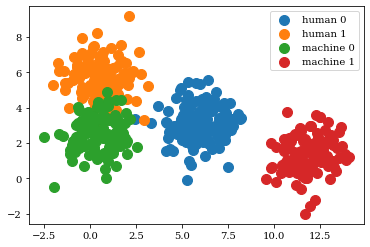

In [ ]:

d = 2
total_samples = 500
mean_scale = 12
variance = 1.0
group_proportion = 0.5#np.random.uniform()
if group_proportion <= 0.02:
    group_proportion = 0.02
if group_proportion >= 0.98:
    group_proportion = 0.98
#group_proportion = 0.4
cluster1_mean = torch.rand(d)*mean_scale
cluster1_var = torch.tensor(variance)#torch.rand(d)*d
cluster1 = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster2_mean = torch.rand(d)*mean_scale
cluster2_var = torch.tensor(variance)#torch.rand(d)*d
cluster2 = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster3_mean = torch.rand(d)*mean_scale
cluster3_var = torch.tensor(variance)#torch.rand(d)*d
cluster3 = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_mean = torch.rand(d)*mean_scale
cluster4_var = torch.tensor(variance)#torch.rand(d)*d
cluster4 = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

# test data
cluster1_test = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels_test = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster2_test = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels_test = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster3_test = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels_test = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_test = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels_test = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

fig, ax = plt.subplots(1)
x1 = cluster1.numpy()
x2 = cluster2.numpy()
x3 = cluster3.numpy()
x4 = cluster4.numpy()
epsilon = 0.8
ax.set_facecolor('white')
#ax.set(xlim=(-4, 10), ylim=(-4, 10))
#ax.vlines([-12,-6,0,6,12.3],-12,12.3)
#ax.hlines([-12,-6,0,6,12.3],-12,12.3)
#ax.plot([x1h, x2h], [y1h, y2h], color='red', marker='x',label = "human")
#ax.plot([x1m, x2m], [y1m, y2m], color='blue', marker='x',label = "machine")

scatter = mscatter(x1[:, 0], x1[:, 1],  cmap='RdBu',  ax=ax,s=100, label="human 0")
scatter = mscatter(x2[:, 0], x2[:, 1], cmap='RdBu',  ax=ax,s=100, label="human 1")
scatter = mscatter(x3[:, 0], x3[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 0")
scatter = mscatter(x4[:, 0], x4[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 1")
plt.legend()
plt.show()

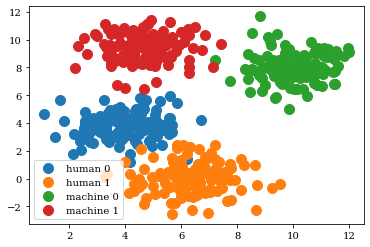

In [ ]:
# expert model
print("Training machine")
net_machine = Linear_net_sig(d)
data_x = torch.cat([cluster3, cluster4])
data_y = torch.cat([cluster3_labels, cluster4_labels])
run_classifier_sig(net_machine, data_x, data_y, 50000)
# expert model
print("Training human")
net_human = Linear_net_sig(d)
data_x = torch.cat([cluster1, cluster2])
data_y = torch.cat([cluster1_labels, cluster2_labels])
run_classifier_sig(net_human, data_x, data_y, 50000)
knn_learner = human_learner_knn()


Training machine
loss 4.140018463134766


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.00879955105483532
loss 0.0053574563935399055
loss 0.003934270236641169
loss 0.0031282638665288687
Training human
loss 2.7601757049560547
loss 0.014824764803051949
loss 0.013185227289795876
loss 0.012607907876372337
loss 0.012321854941546917


In [ ]:
knn_learner = human_learner_knn()


In [ ]:
def conv_to_color(arr):
    cols = []
    for a in arr:
        if a == 1:
            cols.append("blue")
        else:
            cols.append("red")
    return cols

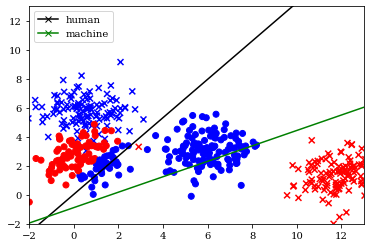

In [ ]:
x1 = cluster1.numpy()
x2 = cluster2.numpy()
x3 = cluster3.numpy()
x4 = cluster4.numpy()
epsilon = 0.9


# get line human
weights = net_human.fc1.weight.detach().numpy()[0]
bias = net_human.fc1.bias.detach().numpy()[0]
x1h =  -100
x2h = 100
y1h = -(1/weights[1])*(weights[0]*x1h + bias)
y2h = -(1/weights[1])*(weights[0]*x2h + bias)

# get line machine
weights = net_machine.fc1.weight.detach().numpy()[0]
bias = net_machine.fc1.bias.detach().numpy()[0]
x1m =  -100
x2m = 100
y1m = -(1/weights[1])*(weights[0]*x1m + bias)
y2m = -(1/weights[1])*(weights[0]*x2m + bias)

data_x = torch.cat([cluster1])
data_y = torch.cat([cluster1_labels])
mists1, _ = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)

data_x = torch.cat([cluster2])
data_y = torch.cat([cluster2_labels])
mists2, _ = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)

data_x = torch.cat([cluster3])
data_y = torch.cat([cluster3_labels])
mists3, _ = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)

data_x = torch.cat([cluster4])
data_y = torch.cat([cluster4_labels])
mists4, _ = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)


fig, ax = plt.subplots(1)

ax.set_facecolor('white')
ax.set(xlim=(-2, 13), ylim=(-2, 13))
#ax.vlines([-12,-6,0,6,12.3],-12,12.3)
#ax.hlines([-12,-6,0,6,12.3],-12,12.3)
ax.plot([x1h, x2h], [y1h, y2h], color='black', marker='x',label = "human")
ax.plot([x1m, x2m], [y1m, y2m], color='green', marker='x',label = "machine")



ax.scatter(x1[:, 0], x1[:, 1], c = conv_to_color(mists1), cmap='RdBu',marker ='o' )
ax.scatter(x2[:, 0], x2[:, 1], c = conv_to_color(mists2), cmap='RdBu',marker ='x' )
ax.scatter(x3[:, 0], x3[:, 1], c = conv_to_color(mists3), cmap='RdBu', marker ='o' )
ax.scatter(x4[:, 0], x4[:, 1], c = conv_to_color(mists4), cmap='RdBu', marker ='x' )

#scatter = mscatter(x1[:, 0], x1[:, 1], c = mists1 , cmap='RdBu',  ax=ax,s=100, label="human 0")
#scatter = mscatter(x2[:, 0], x2[:, 1], c = mists2 , cmap='RdBu',  ax=ax,s=100, label="human 1")
#scatter = mscatter(x3[:, 0], x3[:, 1], c = mists3 , cmap='RdBu',  ax=ax,s=100, label="machine 0")
#scatter = mscatter(x4[:, 0], x4[:, 1], c = mists4 , cmap='RdBu',  ax=ax,s=100, label="machine 1")

plt.legend()
#plt.show()
plt.savefig("figure0.pdf")

In [ ]:
data_x = torch.cat([cluster1, cluster2, cluster3, cluster4])
data_y = torch.cat([cluster1_labels, cluster2_labels, cluster3_labels, cluster4_labels])
test_prior(net_human, net_machine, 0.995, data_x, data_y)

In [ ]:
MAX_TRIALS = 1
RESOLUTION = 1
MAX_SIZE = 10
knn_learner_0 = human_learner_knn()
epsilon = 0.9
knn_learner = human_learner_knn()
data_sizes  = []
indices_used = []
test_errors = [[] for _ in range(MAX_TRIALS)]
data_x = torch.cat([cluster1, cluster2, cluster3, cluster4])
data_y = torch.cat([cluster1_labels, cluster2_labels, cluster3_labels, cluster4_labels])
data_x_np = data_x.numpy()
data_y_np = data_y.numpy()
outputs = net_human(data_x)
predicted_hum = torch.round(outputs.data).numpy()[:,0]
outputs = net_machine(data_x)
predicted_mach = torch.round(outputs.data).numpy()[:,0]
points_chosen = []


In [ ]:
MAX_TRIALS = 1
RESOLUTION = 1
MAX_SIZE = 10
knn_learner_0 = human_learner_knn()
epsilon = 0.9

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
def kernel_similarity(x, y):
    kernel_dist = rbf_kernel(x.reshape(1, -1),y.reshape(1, -1))
    return kernel_dist[0][0]


In [ ]:
# Optimal deferall decisions
opt_defer_teaching = []
for ex in range(len(predicted_hum)):
    error_hum = (predicted_hum[ex] == data_y[ex])
    error_ai = (predicted_mach[ex] == data_y[ex])
    if error_hum > error_ai:
        opt_defer_teaching.append(1)
    else:
        opt_defer_teaching.append(0)


In [ ]:
# Optimal deferall decisions
opt_defer_teaching = []
for ex in range(len(predicted_hum)):
    error_hum = (predicted_hum[ex] == data_y[ex])
    error_ai = (predicted_mach[ex] == data_y[ex])
    if error_hum > error_ai:
        opt_defer_teaching.append(1)
    else:
        opt_defer_teaching.append(0)

# get optimal gammas
from tqdm import tqdm
optimal_gammas = []
with tqdm(total=len(opt_defer_teaching)) as pbar:
    for i in range(len(opt_defer_teaching)):
        # get all similarities
        opt_defer_ex = opt_defer_teaching[i]
        similarities_embeds = rbf_kernel(data_x_np[i].reshape(1,-1), data_x_np)[0]
        sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(opt_defer_teaching))], key=lambda tup: tup[0])
        indicess = list(range(1, len(opt_defer_teaching)))
        indicess.reverse()

        for k in indicess:
            if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                optimal_gammas.append(sorted_sim[k][0])
                break
        pbar.update(1)

100%|██████████| 500/500 [00:00<00:00, 1344.22it/s]


In [ ]:
def plot(indexx, human_learner, points_chosen):
    x1 = cluster1.numpy()
    x2 = cluster2.numpy()
    x3 = cluster3.numpy()
    x4 = cluster4.numpy()
    epsilon = 0.8
    def Extract(lst, indx): 
        return [item[indx] for item in lst] 

    # get line human
    weights = net_human.fc1.weight.detach().numpy()[0]
    bias = net_human.fc1.bias.detach().numpy()[0]
    x1h =  -100
    x2h = 100
    y1h = -(1/weights[1])*(weights[0]*x1h + bias)
    y2h = -(1/weights[1])*(weights[0]*x2h + bias)

    # get line machine
    weights = net_machine.fc1.weight.detach().numpy()[0]
    bias = net_machine.fc1.bias.detach().numpy()[0]
    x1m =  -100
    x2m = 100
    y1m = -(1/weights[1])*(weights[0]*x1m + bias)
    y2m = -(1/weights[1])*(weights[0]*x2m + bias)

    data_x = torch.cat([cluster1])
    data_y = torch.cat([cluster1_labels])
    mists1, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster2])
    data_y = torch.cat([cluster2_labels])
    mists2, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster3])
    data_y = torch.cat([cluster3_labels])
    mists3, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster4])
    data_y = torch.cat([cluster4_labels])
    mists4, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)


    fig, ax = plt.subplots(1)

    ax.set_facecolor('white')
    ax.set(xlim=(-2, 13), ylim=(-2, 13))
    #ax.vlines([-12,-6,0,6,12.3],-12,12.3)
    #ax.hlines([-12,-6,0,6,12.3],-12,12.3)
    ax.plot([x1h, x2h], [y1h, y2h], color='black', marker='x',label = "human")
    ax.plot([x1m, x2m], [y1m, y2m], color='green', marker='x',label = "machine")



    ax.scatter(x1[:, 0], x1[:, 1], c = conv_to_color(mists1), cmap='RdBu',marker ='o' )
    ax.scatter(x2[:, 0], x2[:, 1], c = conv_to_color(mists2), cmap='RdBu',marker ='x' )
    ax.scatter(x3[:, 0], x3[:, 1], c = conv_to_color(mists3), cmap='RdBu', marker ='o' )
    ax.scatter(x4[:, 0], x4[:, 1], c = conv_to_color(mists4), cmap='RdBu', marker ='x' )

    #scatter = mscatter(x1[:, 0], x1[:, 1], c = mists1 , cmap='RdBu',  ax=ax,s=100, label="human 0")
    #scatter = mscatter(x2[:, 0], x2[:, 1], c = mists2 , cmap='RdBu',  ax=ax,s=100, label="human 1")
    #scatter = mscatter(x3[:, 0], x3[:, 1], c = mists3 , cmap='RdBu',  ax=ax,s=100, label="machine 0")
    #scatter = mscatter(x4[:, 0], x4[:, 1], c = mists4 , cmap='RdBu',  ax=ax,s=100, label="machine 1")
    ax.scatter(Extract(points_chosen,0), Extract(points_chosen,1), label = "points chosen", marker = "X", color="green",s=70 )
    plt.legend()
    plt.savefig("figure"+str(indexx)+".pdf")
    plt.show()

###########################
evaluating at size 0
{'coverage': '459 out of500', 'system accuracy': 58.2, 'expert accuracy': 97.56049970487949, 'classifier accuracy': 54.684083946822675, 'alone classifier': 0.0}
###########################

{'coverage': '459 out of500', 'system accuracy': 58.2, 'expert accuracy': 97.56049970487949, 'classifier accuracy': 54.684083946822675, 'alone classifier': 0.0}
{'coverage': '440 out of500', 'system accuracy': 61.8, 'expert accuracy': 98.33300555664815, 'classifier accuracy': 56.81816890496162, 'alone classifier': 0.0}
{'coverage': '451 out of500', 'system accuracy': 59.8, 'expert accuracy': 97.9587838416986, 'classifier accuracy': 55.6540896554125, 'alone classifier': 0.0}
{'coverage': '459 out of500', 'system accuracy': 58.2, 'expert accuracy': 97.56049970487949, 'classifier accuracy': 54.684083946822675, 'alone classifier': 0.0}
{'coverage': '459 out of500', 'system accuracy': 58.2, 'expert accuracy': 97.56049970487949, 'classifier accuracy': 54.68

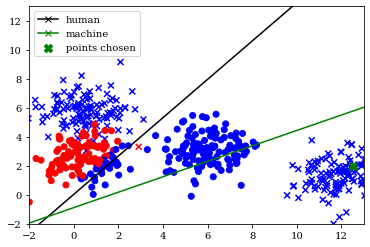

###########################
evaluating at size 1
{'coverage': '334 out of500', 'system accuracy': 83.2, 'expert accuracy': 99.3974706054571, 'classifier accuracy': 75.14967809889878, 'alone classifier': 0.0}
###########################

{'coverage': '334 out of500', 'system accuracy': 83.2, 'expert accuracy': 99.3974706054571, 'classifier accuracy': 75.14967809889878, 'alone classifier': 0.0}
{'coverage': '334 out of500', 'system accuracy': 83.2, 'expert accuracy': 99.3974706054571, 'classifier accuracy': 75.14967809889878, 'alone classifier': 0.0}
{'coverage': '334 out of500', 'system accuracy': 83.2, 'expert accuracy': 99.3974706054571, 'classifier accuracy': 75.14967809889878, 'alone classifier': 0.0}
{'coverage': '334 out of500', 'system accuracy': 83.2, 'expert accuracy': 99.3974706054571, 'classifier accuracy': 75.14967809889878, 'alone classifier': 0.0}
{'coverage': '315 out of500', 'system accuracy': 86.8, 'expert accuracy': 99.45935193583574, 'classifier accuracy': 79.36505416

<Figure size 432x288 with 0 Axes>

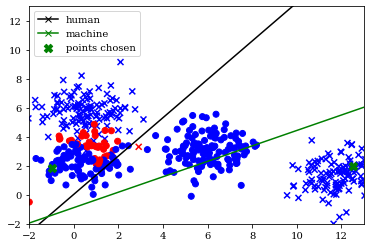

###########################
evaluating at size 2
{'coverage': '281 out of500', 'system accuracy': 93.8, 'expert accuracy': 99.54328808832138, 'classifier accuracy': 89.32381162853679, 'alone classifier': 0.0}
###########################

{'coverage': '281 out of500', 'system accuracy': 93.8, 'expert accuracy': 99.54328808832138, 'classifier accuracy': 89.32381162853679, 'alone classifier': 0.0}
{'coverage': '281 out of500', 'system accuracy': 93.8, 'expert accuracy': 99.54328808832138, 'classifier accuracy': 89.32381162853679, 'alone classifier': 0.0}
{'coverage': '277 out of500', 'system accuracy': 94.2, 'expert accuracy': 99.55148022288769, 'classifier accuracy': 89.89166429903817, 'alone classifier': 0.0}
{'coverage': '281 out of500', 'system accuracy': 93.8, 'expert accuracy': 99.54328808832138, 'classifier accuracy': 89.32381162853679, 'alone classifier': 0.0}
{'coverage': '281 out of500', 'system accuracy': 93.8, 'expert accuracy': 99.54328808832138, 'classifier accuracy': 89.323

<Figure size 432x288 with 0 Axes>

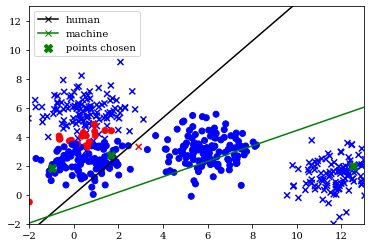

###########################
evaluating at size 3
{'coverage': '271 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56323182250496, 'classifier accuracy': 92.61989202218007, 'alone classifier': 0.0}
###########################

{'coverage': '271 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56323182250496, 'classifier accuracy': 92.61989202218007, 'alone classifier': 0.0}
{'coverage': '271 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56323182250496, 'classifier accuracy': 92.61989202218007, 'alone classifier': 0.0}
{'coverage': '271 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56323182250496, 'classifier accuracy': 92.61989202218007, 'alone classifier': 0.0}
{'coverage': '271 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56323182250496, 'classifier accuracy': 92.61989202218007, 'alone classifier': 0.0}
{'coverage': '270 out of500', 'system accuracy': 95.8, 'expert accuracy': 99.56513081292972, 'classifier accuracy': 92.592

<Figure size 432x288 with 0 Axes>

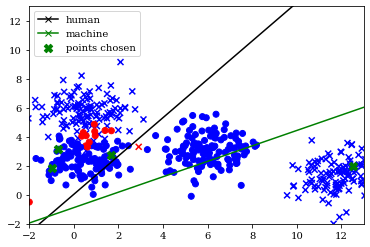

###########################
evaluating at size 4
{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.07572156222669, 'alone classifier': 0.0}
###########################

{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.07572156222669, 'alone classifier': 0.0}
{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.07572156222669, 'alone classifier': 0.0}
{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.07572156222669, 'alone classifier': 0.0}
{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.07572156222669, 'alone classifier': 0.0}
{'coverage': '264 out of500', 'system accuracy': 97.2, 'expert accuracy': 99.5761867998417, 'classifier accuracy': 95.075721562

<Figure size 432x288 with 0 Axes>

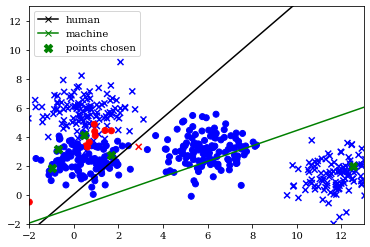

###########################
evaluating at size 5
{'coverage': '260 out of500', 'system accuracy': 98.0, 'expert accuracy': 99.58325034729137, 'classifier accuracy': 96.53842440829831, 'alone classifier': 0.0}
###########################

{'coverage': '260 out of500', 'system accuracy': 98.0, 'expert accuracy': 99.58325034729137, 'classifier accuracy': 96.53842440829831, 'alone classifier': 0.0}
{'coverage': '260 out of500', 'system accuracy': 98.0, 'expert accuracy': 99.58325034729137, 'classifier accuracy': 96.53842440829831, 'alone classifier': 0.0}
{'coverage': '260 out of500', 'system accuracy': 98.0, 'expert accuracy': 99.58325034729137, 'classifier accuracy': 96.53842440829831, 'alone classifier': 0.0}
{'coverage': '259 out of500', 'system accuracy': 98.2, 'expert accuracy': 99.58497959752731, 'classifier accuracy': 96.91115949376082, 'alone classifier': 0.0}
{'coverage': '260 out of500', 'system accuracy': 98.0, 'expert accuracy': 99.58325034729137, 'classifier accuracy': 96.538

<Figure size 432x288 with 0 Axes>

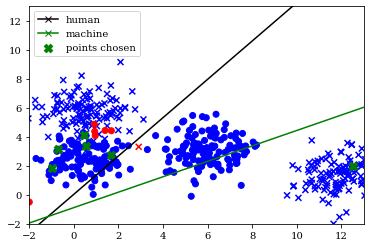

###########################
evaluating at size 6
{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.66533164773088, 'alone classifier': 0.0}
###########################

{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.66533164773088, 'alone classifier': 0.0}
{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.66533164773088, 'alone classifier': 0.0}
{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.66533164773088, 'alone classifier': 0.0}
{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.66533164773088, 'alone classifier': 0.0}
{'coverage': '257 out of500', 'system accuracy': 98.6, 'expert accuracy': 99.5883954004976, 'classifier accuracy': 97.665331647

<Figure size 432x288 with 0 Axes>

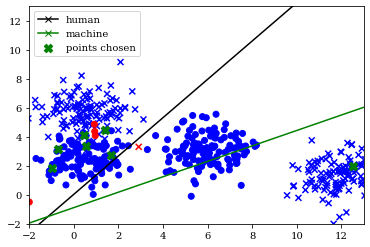

###########################
evaluating at size 7
{'coverage': '255 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59175543530168, 'classifier accuracy': 98.43133394849649, 'alone classifier': 0.0}
###########################

{'coverage': '255 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59175543530168, 'classifier accuracy': 98.43133394849649, 'alone classifier': 0.0}
{'coverage': '255 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59175543530168, 'classifier accuracy': 98.43133394849649, 'alone classifier': 0.0}
{'coverage': '255 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59175543530168, 'classifier accuracy': 98.43133394849649, 'alone classifier': 0.0}
{'coverage': '253 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59506105663073, 'classifier accuracy': 98.4189334312516, 'alone classifier': 0.0}
{'coverage': '255 out of500', 'system accuracy': 99.0, 'expert accuracy': 99.59175543530168, 'classifier accuracy': 98.4313

<Figure size 432x288 with 0 Axes>

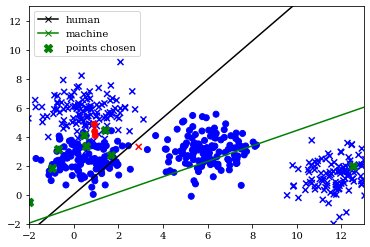

###########################
evaluating at size 8
{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.80948459941087, 'alone classifier': 0.0}
###########################

{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.80948459941087, 'alone classifier': 0.0}
{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.80948459941087, 'alone classifier': 0.0}
{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.80948459941087, 'alone classifier': 0.0}
{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.80948459941087, 'alone classifier': 0.0}
{'coverage': '252 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.59669387363397, 'classifier accuracy': 98.809

<Figure size 432x288 with 0 Axes>

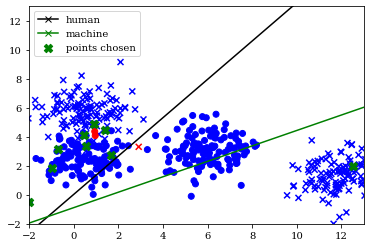

###########################
evaluating at size 9
{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.20314772782959, 'alone classifier': 0.0}
###########################

{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.20314772782959, 'alone classifier': 0.0}
{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.20314772782959, 'alone classifier': 0.0}
{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.20314772782959, 'alone classifier': 0.0}
{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.20314772782959, 'alone classifier': 0.0}
{'coverage': '251 out of500', 'system accuracy': 99.4, 'expert accuracy': 99.59831357565174, 'classifier accuracy': 99.203

<Figure size 432x288 with 0 Axes>

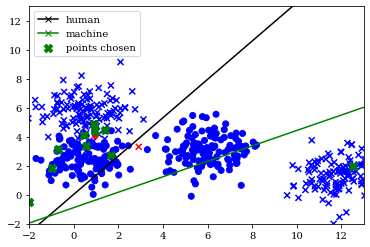

<Figure size 432x288 with 0 Axes>

In [ ]:
knn_learner = human_learner_knn()

for trial in range(MAX_TRIALS):
    for itt in range(10):
        best_index = -1
        best_value = 0
        if itt % RESOLUTION == 0:
            print("###########################")
            print("evaluating at size " + str(itt) )
            _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)
            print(metrics)
            print("###########################")
            test_errors[trial].append(metrics["system accuracy"])
            data_sizes.append(itt)

        valid_indices = list(set(list(range(len(data_x_np)))) - set(indices_used))
        subset_size = max(200, len(valid_indices))
        random_teach_subset = random.sample(valid_indices, subset_size) # used to take gradient steps
        print("")
        # for each point, add and see effect then remove
        for j in random_teach_subset:

            repr_x = data_x_np[j]
            target = data_y_np[j]
            correct_deferal = 0
            if target == predicted_hum[j]:
                correct_deferal = 0
            elif target == predicted_mach[j]:
                correct_deferal = 1
            knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[j]))
            _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)
            if j % 25 == 0:
                print(metrics)
            acc = metrics["system accuracy"]
            if acc >= best_value:
                best_value = acc
                best_index = j
            knn_learner.remove_teaching()

        indices_used.append(best_index) # add found element to set used
        repr_x = data_x_np[best_index]
        target = data_y_np[best_index] 
        points_chosen.append(repr_x)
        correct_deferal = 0
        if target == predicted_hum[best_index]:
            correct_deferal = 0
        elif target == predicted_mach[best_index]:
            correct_deferal = 1
        knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[best_index]))
        points_chosen = [list(pp) for pp in points_chosen]
        plot(1, knn_learner, points_chosen)

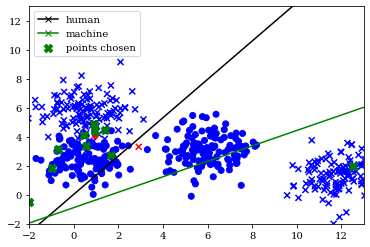

In [ ]:
plot(1, knn_learner, points_chosen)

In [ ]:
points_chosen = np.array(points_chosen[0])

In [ ]:
points_chosen = [list(pp) for pp in points_chosen]

In [ ]:

kmedoids = KMedoids(n_clusters=10, init='k-medoids++', max_iter=100000).fit(data_x_np)
print(kmedoids.inertia_)
teaching_indices = kmedoids.medoid_indices_


429.22876


In [ ]:
teaching_indices

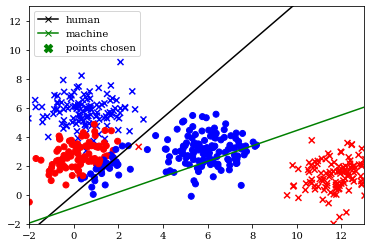

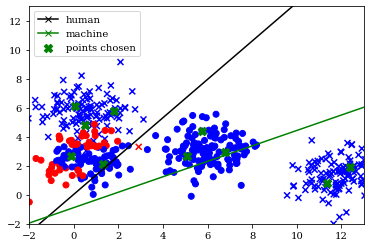

In [ ]:

knn_learner = human_learner_knn()
points_chosen = []
plot(0, knn_learner, points_chosen)
for teach_ex_idx in teaching_indices:
    _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x, data_y)
    target = data_y_np[teach_ex_idx] 
    correct_deferal = 0
    if target == predicted_hum[teach_ex_idx]:
        correct_deferal = 0
    elif target == predicted_mach[teach_ex_idx]:
        correct_deferal = 1
    gamma = optimal_gammas[teach_ex_idx] # random choice
    ex_x = data_x_np[teach_ex_idx]
    teach_example = (ex_x, correct_deferal, gamma)
    knn_learner.add_to_teaching(teach_example)
    points_chosen.append(data_x_np[teach_ex_idx])
    points_chosen = [list(pp) for pp in points_chosen]
plot(2, knn_learner, points_chosen)

In [ ]:
knn_learner = human_learner_knn()
points_chosen = []
indices_used = []
set_xs = []
set_ys = []
for itt in range(10):
    best_index = -1
    best_value = 0

    valid_indices = list(set(list(range(len(data_x_np)))) - set(indices_used))
    subset_size = min(500, len(valid_indices)-1)
    random_teach_subset = random.sample(valid_indices, subset_size) # used to take gradient steps
    random_validation_subset = random.sample(valid_indices, subset_size)
    from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
    neigh = RadiusNeighborsClassifier(radius=100, weights='distance')
    # for each point, add and see effect then remove
    for j in random_teach_subset:
        x_try = data_x_np[j]
        y_try = predicted_mach[j]
        set_xs.append(x_try)
        set_ys.append(y_try)
        np_set_xs = np.asarray(set_xs)
        np_set_ys = np.asarray(set_ys)
        neigh = RadiusNeighborsClassifier(radius=100, weights='distance')
        neigh.fit(np_set_xs, np_set_ys)
        acc = neigh.score(data_x_np, predicted_mach)
        if acc >= best_value:
            best_value = acc
            best_index = j
        set_xs = set_xs[:-1]
        set_ys = set_ys[:-1]

    x_try = data_x_np[best_index]
    y_try = predicted_mach[best_index]
    set_xs.append(x_try)
    set_ys.append(y_try)
    indices_used.append(best_index) # add found element to set used
    repr_x = data_x_np[best_index]
    target = data_y_np[best_index] 
    points_chosen.append(repr_x)
    correct_deferal = 0
    if target == predicted_hum[best_index]:
        correct_deferal = 0
    elif target == predicted_mach[best_index]:
        correct_deferal = 1
    knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[best_index]))
    points_chosen = [list(pp) for pp in points_chosen]
    print("###########################")
    print("evaluating at size " + str(itt) )
    _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x_test, data_y_test)
    print(metrics)
    print("###########################")
    scores_aibaseline[trial].append(metrics["system accuracy"])



###########################
evaluating at size 0
{'coverage': '408 out of500', 'system accuracy': 62.6, 'expert accuracy': 96.73892013278231, 'classifier accuracy': 54.90194732795409, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '400 out of500', 'system accuracy': 64.2, 'expert accuracy': 96.99980600038799, 'classifier accuracy': 55.9999860000035, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '400 out of500', 'system accuracy': 64.2, 'expert accuracy': 96.99980600038799, 'classifier accuracy': 55.9999860000035, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '392 out of500', 'system accuracy': 65.8, 'expert accuracy': 97.22204218140337, 'classifier accuracy': 57.14284256560139, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cov

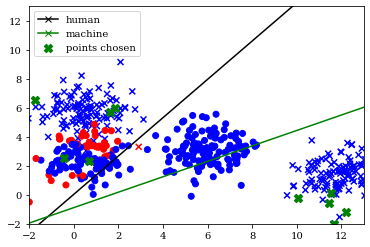

In [ ]:
plot(2, knn_learner, points_chosen)

# Experimental Setup

In [ ]:
from sklearn.neighbors import RadiusNeighborsClassifier
neigh = RadiusNeighborsClassifier(radius=100, weights='distance')
neigh.fit(data_x_np[:], predicted_mach[:])
neigh.score(data_x_np, predicted_mach)

'''
outputs = net_machine(data_x_test)
predicted_mach_test = torch.round(outputs.data).numpy()[:,0]
neigh.score(data_x_np_test, predicted_mach_test)
'''


1.0

In [ ]:
predicted_mach

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [ ]:
max_trials = 15
max_subset_size = 15
epsilon = 0.8
scores_ours = [[] for _ in range(max_trials)]
scores_baseline = [[] for _ in range(max_trials)]
scores_random = [[] for _ in range(max_trials)]
scores_aibaseline = [[] for _ in range(max_trials)]

for trial in range(max_trials):
    # GENERATE DATA
    d = 2
    total_samples = 500
    mean_scale = 10
    variance = 1.0
    group_proportion = 0.5#np.random.uniform()
    if group_proportion <= 0.02:
        group_proportion = 0.02
    if group_proportion >= 0.98:
        group_proportion = 0.98
    #group_proportion = 0.4
    cluster1_mean = torch.rand(d)*mean_scale
    cluster1_var = torch.tensor(variance)#torch.rand(d)*d
    cluster1 = sample(
        cluster1_mean,
        cluster1_var,
        nb_samples= math.floor(total_samples * group_proportion * 0.5 )
    )
    cluster1_labels = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
    cluster2_mean = torch.rand(d)*mean_scale
    cluster2_var = torch.tensor(variance)#torch.rand(d)*d
    cluster2 = sample(
        cluster2_mean,
        cluster2_var,
        nb_samples= math.floor(total_samples * group_proportion * 0.5 )
    )
    cluster2_labels = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
    cluster3_mean = torch.rand(d)*mean_scale
    cluster3_var = torch.tensor(variance)#torch.rand(d)*d
    cluster3 = sample(
        cluster3_mean,
        cluster3_var,
        nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
    )
    cluster3_labels = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

    cluster4_mean = torch.rand(d)*mean_scale
    cluster4_var = torch.tensor(variance)#torch.rand(d)*d
    cluster4 = sample(
        cluster4_mean,
        cluster4_var,
        nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
    )
    cluster4_labels = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

    # test data
    cluster1_test = sample(
        cluster1_mean,
        cluster1_var,
        nb_samples= math.floor(total_samples * group_proportion * 0.5 )
    )
    cluster1_labels_test = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

    cluster2_test = sample(
        cluster2_mean,
        cluster2_var,
        nb_samples= math.floor(total_samples * group_proportion * 0.5 )
    )
    cluster2_labels_test = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

    cluster3_test = sample(
        cluster3_mean,
        cluster3_var,
        nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
    )
    cluster3_labels_test = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

    cluster4_test = sample(
        cluster4_mean,
        cluster4_var,
        nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
    )
    cluster4_labels_test = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

    # expert model
    print("Training machine")
    net_machine = Linear_net_sig(d)
    data_x = torch.cat([cluster3, cluster4])
    data_y = torch.cat([cluster3_labels, cluster4_labels])
    run_classifier_sig(net_machine, data_x, data_y, 50000)
    # expert model
    print("Training human")
    net_human = Linear_net_sig(d)
    data_x = torch.cat([cluster1, cluster2])
    data_y = torch.cat([cluster1_labels, cluster2_labels])
    run_classifier_sig(net_human, data_x, data_y, 50000)
    knn_learner = human_learner_knn()


    knn_learner = human_learner_knn()
    data_sizes  = []
    indices_used = []
    data_x = torch.cat([cluster1, cluster2, cluster3, cluster4])
    data_y = torch.cat([cluster1_labels, cluster2_labels, cluster3_labels, cluster4_labels])
    data_x_np = data_x.numpy()
    data_y_np = data_y.numpy()

    data_x_test = torch.cat([cluster1_test, cluster2_test, cluster3_test, cluster4_test])
    data_y_test = torch.cat([cluster1_labels_test, cluster2_labels_test, cluster3_labels_test, cluster4_labels_test])
    data_x_np_test = data_x_test.numpy()
    data_y_np_test = data_y_test.numpy()
    outputs = net_human(data_x)
    predicted_hum = torch.round(outputs.data).numpy()[:,0]
    outputs = net_machine(data_x)
    predicted_mach = torch.round(outputs.data).numpy()[:,0]
    points_chosen = []

    # Optimal deferall decisions
    opt_defer_teaching = []
    for ex in range(len(predicted_hum)):
        error_hum = (predicted_hum[ex] == data_y[ex])
        error_ai = (predicted_mach[ex] == data_y[ex])
        if error_hum > error_ai:
            opt_defer_teaching.append(1)
        else:
            opt_defer_teaching.append(0)

    # get optimal gammas
    optimal_gammas = []
    with tqdm(total=len(opt_defer_teaching)) as pbar:
        for i in range(len(opt_defer_teaching)):
            # get all similarities
            opt_defer_ex = opt_defer_teaching[i]
            similarities_embeds = rbf_kernel(data_x_np[i].reshape(1,-1), data_x_np)[0]
            sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(opt_defer_teaching))], key=lambda tup: tup[0])
            indicess = list(range(1, len(opt_defer_teaching)))
            indicess.reverse()
            found_gamma = False
            for k in indicess:
                if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                    optimal_gammas.append(sorted_sim[k][0])
                    found_gamma = True 
                    break
            if not found_gamma:
                optimal_gammas.append(1)
            pbar.update(1)


    # my approach
    for itt in range(max_subset_size):
        best_index = -1
        best_value = 0

        valid_indices = list(set(list(range(len(data_x_np)))) - set(indices_used))
        subset_size = min(100, len(valid_indices)-1)
        random_teach_subset = random.sample(valid_indices, subset_size) # used to take gradient steps
        random_validation_subset = random.sample(valid_indices, subset_size)

        # for each point, add and see effect then remove
        for j in random_teach_subset:

            repr_x = data_x_np[j]
            target = data_y_np[j]
            correct_deferal = 0
            if target == predicted_hum[j]:
                correct_deferal = 0
            elif target == predicted_mach[j]:
                correct_deferal = 1
            knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[j]))
            _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, torch.stack([data_x[i] for i in random_validation_subset]), torch.stack([data_y[i] for i in random_validation_subset]))
            acc = metrics["system accuracy"]
            if acc >= best_value:
                best_value = acc
                best_index = j
            knn_learner.remove_teaching()

        indices_used.append(best_index) # add found element to set used
        repr_x = data_x_np[best_index]
        target = data_y_np[best_index] 
        points_chosen.append(repr_x)
        correct_deferal = 0
        if target == predicted_hum[best_index]:
            correct_deferal = 0
        elif target == predicted_mach[best_index]:
            correct_deferal = 1
        knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[best_index]))
        points_chosen = [list(pp) for pp in points_chosen]
        print("###########################")
        print("evaluating at size " + str(itt) )
        _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x_test, data_y_test)
        print(metrics)
        print("###########################")
        scores_ours[trial].append(metrics["system accuracy"])


    # learn ai behavior
    knn_learner = human_learner_knn()
    indices_used = []
    set_xs = []
    set_ys = []
    for itt in range(max_subset_size):
        best_index = -1
        best_value = 0

        valid_indices = list(set(list(range(len(data_x_np)))) - set(indices_used))
        subset_size = min(500, len(valid_indices)-1)
        random_teach_subset = random.sample(valid_indices, subset_size) # used to take gradient steps
        random_validation_subset = random.sample(valid_indices, subset_size)
        from sklearn.neighbors import RadiusNeighborsClassifier, KNeighborsClassifier
        neigh = RadiusNeighborsClassifier(radius=100, weights='distance')
        # for each point, add and see effect then remove
        for j in random_teach_subset:
            x_try = data_x_np[j]
            y_try = predicted_mach[j]
            set_xs.append(x_try)
            set_ys.append(y_try)
            np_set_xs = np.asarray(set_xs)
            np_set_ys = np.asarray(set_ys)
            neigh = RadiusNeighborsClassifier(radius=100, weights='distance')
            neigh.fit(np_set_xs, np_set_ys)
            acc = neigh.score(data_x_np, predicted_mach)
            if acc >= best_value:
                best_value = acc
                best_index = j
            set_xs = set_xs[:-1]
            set_ys = set_ys[:-1]

        x_try = data_x_np[best_index]
        y_try = predicted_mach[best_index]
        set_xs.append(x_try)
        set_ys.append(y_try)
        indices_used.append(best_index) # add found element to set used
        repr_x = data_x_np[best_index]
        target = data_y_np[best_index] 
        points_chosen.append(repr_x)
        correct_deferal = 0
        if target == predicted_hum[best_index]:
            correct_deferal = 0
        elif target == predicted_mach[best_index]:
            correct_deferal = 1
        knn_learner.add_to_teaching((repr_x, correct_deferal, optimal_gammas[best_index]))
        points_chosen = [list(pp) for pp in points_chosen]
        print("###########################")
        print("evaluating at size " + str(itt) )
        _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x_test, data_y_test)
        print(metrics)
        print("###########################")
        scores_aibaseline[trial].append(metrics["system accuracy"])



    # baseline

    for size_subset in range(1, max_subset_size + 1):
        kmedoids = KMedoids(n_clusters=size_subset, init='k-medoids++', max_iter=1000).fit(data_x_np)
        teaching_indices = kmedoids.medoid_indices_

        knn_learner = human_learner_knn()
        points_chosen = []
        for teach_ex_idx in teaching_indices:
            target = data_y_np[teach_ex_idx] 
            correct_deferal = 0
            if target == predicted_hum[teach_ex_idx]:
                correct_deferal = 0
            elif target == predicted_mach[teach_ex_idx]:
                correct_deferal = 1
            gamma = optimal_gammas[teach_ex_idx] # random choice
            ex_x = data_x_np[teach_ex_idx]
            teach_example = (ex_x, correct_deferal, gamma)
            knn_learner.add_to_teaching(teach_example)
        _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x_test, data_y_test)
        scores_baseline[trial].append(metrics["system accuracy"])
        print(metrics['system accuracy'])

    for size_subset in range(1, max_subset_size + 1):
        random_teach_subset = random.sample(list(range(len(data_x_np))), size_subset) # used to take gradient steps
        knn_learner = human_learner_knn()
        for teach_ex_idx in random_teach_subset:
            target = data_y_np[teach_ex_idx] 
            correct_deferal = 0
            if target == predicted_hum[teach_ex_idx]:
                correct_deferal = 0
            elif target == predicted_mach[teach_ex_idx]:
                correct_deferal = 1
            gamma = optimal_gammas[teach_ex_idx] # random choice
            ex_x = data_x_np[teach_ex_idx]
            teach_example = (ex_x, correct_deferal, gamma)
            knn_learner.add_to_teaching(teach_example)
        _, metrics = test_posterior(net_human, net_machine, epsilon, knn_learner, data_x_test, data_y_test)
        scores_random[trial].append(metrics["system accuracy"])

Training machine
loss 0.6139005422592163


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.5576422214508057
loss 0.5441154837608337
loss 0.5388452410697937
loss 0.5366835594177246
Training human
loss 0.44762489199638367
loss 0.01923512853682041
loss 0.014368319883942604
loss 0.01207560021430254
loss 0.01063709706068039


100%|██████████| 500/500 [00:00<00:00, 1361.50it/s]


###########################
evaluating at size 0
{'coverage': '466 out of500', 'system accuracy': 77.4, 'expert accuracy': 79.41129758060247, 'classifier accuracy': 77.25320230617977, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '453 out of500', 'system accuracy': 78.0, 'expert accuracy': 74.46776822226289, 'classifier accuracy': 78.36642861668243, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '445 out of500', 'system accuracy': 79.6, 'expert accuracy': 78.18153388533133, 'classifier accuracy': 79.77526297185102, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '440 out of500', 'system accuracy': 80.2, 'expert accuracy': 78.33307222309259, 'classifier accuracy': 80.45452716942565, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'c

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.12190661579370499
loss 0.08278387784957886
loss 0.06572751700878143
loss 0.055880989879369736
Training human
loss 0.8533300161361694
loss 0.021661533042788506
loss 0.011114859022200108
loss 0.00755827222019434
loss 0.005759994499385357


100%|██████████| 500/500 [00:00<00:00, 1411.78it/s]


###########################
evaluating at size 0
{'coverage': '461 out of500', 'system accuracy': 99.2, 'expert accuracy': 92.30721893733879, 'classifier accuracy': 99.7830586153886, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '461 out of500', 'system accuracy': 99.2, 'expert accuracy': 92.30721893733879, 'classifier accuracy': 99.7830586153886, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '461 out of500', 'system accuracy': 99.2, 'expert accuracy': 92.30721893733879, 'classifier accuracy': 99.7830586153886, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '461 out of500', 'system accuracy': 99.2, 'expert accuracy': 92.30721893733879, 'classifier accuracy': 99.7830586153886, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cover

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.0798037052154541
loss 0.07748797535896301
loss 0.07666408270597458
loss 0.07609359920024872
Training human
loss 0.4152856469154358
loss 0.03991888836026192
loss 0.0244001317769289
loss 0.018482811748981476
loss 0.015251431614160538


100%|██████████| 500/500 [00:00<00:00, 1436.09it/s]


###########################
evaluating at size 0
{'coverage': '335 out of500', 'system accuracy': 92.0, 'expert accuracy': 96.96957943081281, 'classifier accuracy': 89.55221207396656, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '279 out of500', 'system accuracy': 95.0, 'expert accuracy': 97.28497983259743, 'classifier accuracy': 93.18993075629723, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '277 out of500', 'system accuracy': 95.4, 'expert accuracy': 97.30932976741724, 'classifier accuracy': 93.86278199899567, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '277 out of500', 'system accuracy': 95.4, 'expert accuracy': 97.30932976741724, 'classifier accuracy': 93.86278199899567, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'c

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.0015091451350599527
loss 0.000832528225146234
loss 0.000586079666391015
loss 0.00045621287426911294
Training human
loss 5.039898872375488
loss 0.3151107728481293
loss 0.2596907615661621
loss 0.2259625643491745
loss 0.20382444560527802


100%|██████████| 500/500 [00:00<00:00, 1322.24it/s]


###########################
evaluating at size 0
{'coverage': '453 out of500', 'system accuracy': 92.0, 'expert accuracy': 36.170058850813405, 'classifier accuracy': 97.79247289349385, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '457 out of500', 'system accuracy': 92.8, 'expert accuracy': 39.534699838605405, 'classifier accuracy': 97.81179478954162, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '471 out of500', 'system accuracy': 95.4, 'expert accuracy': 55.1720332963221, 'classifier accuracy': 97.87683696882443, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '475 out of500', 'system accuracy': 96.2, 'expert accuracy': 63.999488004095966, 'classifier accuracy': 97.89471623269132, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.01930614747107029
loss 0.015056719072163105
loss 0.013108608312904835
loss 0.011861593462526798
Training human
loss 3.3948771953582764
loss 0.28052186965942383
loss 0.2031332403421402
loss 0.17240259051322937
loss 0.15576615929603577


100%|██████████| 500/500 [00:00<00:00, 1404.07it/s]


###########################
evaluating at size 0
{'coverage': '337 out of500', 'system accuracy': 94.4, 'expert accuracy': 88.95694606509684, 'classifier accuracy': 97.03261215649492, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '341 out of500', 'system accuracy': 94.8, 'expert accuracy': 90.56592381644802, 'classifier accuracy': 96.77416516886653, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '365 out of500', 'system accuracy': 94.8, 'expert accuracy': 91.11097613188721, 'classifier accuracy': 96.1643572152446, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '368 out of500', 'system accuracy': 94.6, 'expert accuracy': 90.90895316825276, 'classifier accuracy': 95.92388697720463, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'co

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.03005971759557724
loss 0.01630249060690403
loss 0.011438393034040928
loss 0.00891045480966568
Training human
loss 0.35654982924461365
loss 0.10695391893386841
loss 0.08819276094436646
loss 0.08061867952346802
loss 0.07663080841302872


100%|██████████| 500/500 [00:00<00:00, 1412.84it/s]


###########################
evaluating at size 0
{'coverage': '350 out of500', 'system accuracy': 76.0, 'expert accuracy': 93.99987466683378, 'classifier accuracy': 68.28569477551578, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '335 out of500', 'system accuracy': 77.8, 'expert accuracy': 92.72716033071475, 'classifier accuracy': 70.44774016485368, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '333 out of500', 'system accuracy': 77.8, 'expert accuracy': 92.21545842460068, 'classifier accuracy': 70.5705493782134, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '331 out of500', 'system accuracy': 78.2, 'expert accuracy': 92.30758306794903, 'classifier accuracy': 70.99695740273191, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'co

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.2755005955696106
loss 0.21282051503658295
loss 0.1854127198457718
loss 0.17011228203773499
Training human
loss 0.6456725001335144
loss 0.09788952022790909
loss 0.07027396559715271
loss 0.060395922511816025
loss 0.05531422421336174


100%|██████████| 500/500 [00:00<00:00, 1469.99it/s]


###########################
evaluating at size 0
{'coverage': '407 out of500', 'system accuracy': 73.4, 'expert accuracy': 92.47291941307653, 'classifier accuracy': 69.0417520781936, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '374 out of500', 'system accuracy': 80.0, 'expert accuracy': 94.44429453286581, 'classifier accuracy': 75.1336697503557, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '361 out of500', 'system accuracy': 82.6, 'expert accuracy': 94.96389213828469, 'classifier accuracy': 77.83931361791868, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '359 out of500', 'system accuracy': 82.2, 'expert accuracy': 93.616888486683, 'classifier accuracy': 77.71585578945522, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cover

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.033784959465265274
loss 0.019286496564745903
loss 0.013618523254990578
loss 0.010606394149363041
Training human
loss 0.5904673337936401
loss 0.10973053425550461
loss 0.10707923769950867
loss 0.10504452884197235
loss 0.10325261205434799


100%|██████████| 500/500 [00:00<00:00, 1307.26it/s]


###########################
evaluating at size 0
{'coverage': '355 out of500', 'system accuracy': 97.8, 'expert accuracy': 93.79297407865644, 'classifier accuracy': 99.43659170800234, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '357 out of500', 'system accuracy': 97.8, 'expert accuracy': 94.4054623699827, 'classifier accuracy': 99.1596360897378, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '359 out of500', 'system accuracy': 97.8, 'expert accuracy': 95.03532619102667, 'classifier accuracy': 98.8857663270846, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '359 out of500', 'system accuracy': 97.8, 'expert accuracy': 95.03532619102667, 'classifier accuracy': 98.8857663270846, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cover

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.6352130174636841
loss 0.6314581632614136
loss 0.6290464997291565
loss 0.6274938583374023
Training human
loss 2.231389045715332
loss 0.12751252949237823
loss 0.12572617828845978
loss 0.12431822717189789
loss 0.12304958701133728


100%|██████████| 500/500 [00:00<00:00, 1493.66it/s]


###########################
evaluating at size 0
{'coverage': '485 out of500', 'system accuracy': 73.0, 'expert accuracy': 39.99946667377768, 'classifier accuracy': 74.02060329472097, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '481 out of500', 'system accuracy': 73.0, 'expert accuracy': 42.10481994926369, 'classifier accuracy': 74.2203587899462, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '482 out of500', 'system accuracy': 73.2, 'expert accuracy': 44.443950622770856, 'classifier accuracy': 74.27384351165072, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '482 out of500', 'system accuracy': 73.2, 'expert accuracy': 44.443950622770856, 'classifier accuracy': 74.27384351165072, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.12024246156215668
loss 0.08581094443798065
loss 0.06791932135820389
loss 0.05733781307935715
Training human
loss 1.165763020515442
loss 0.5303919315338135
loss 0.47979211807250977
loss 0.4537748694419861
loss 0.43876102566719055


100%|██████████| 500/500 [00:00<00:00, 1319.31it/s]


###########################
evaluating at size 0
{'coverage': '182 out of500', 'system accuracy': 83.2, 'expert accuracy': 74.52825501367609, 'classifier accuracy': 98.35159431231081, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '191 out of500', 'system accuracy': 83.8, 'expert accuracy': 75.72810632485027, 'classifier accuracy': 96.85858803215287, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '202 out of500', 'system accuracy': 86.0, 'expert accuracy': 78.52343723259246, 'classifier accuracy': 97.02965493581439, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '208 out of500', 'system accuracy': 86.0, 'expert accuracy': 79.10953485648297, 'classifier accuracy': 95.67303092642744, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'c

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.004154117777943611
loss 0.002583121880888939
loss 0.001963845919817686
loss 0.0016181612154468894
Training human
loss 1.6397336721420288
loss 0.5586512684822083
loss 0.5135964155197144
loss 0.4950593113899231
loss 0.48598992824554443


100%|██████████| 500/500 [00:00<00:00, 1340.69it/s]


###########################
evaluating at size 0
{'coverage': '239 out of500', 'system accuracy': 84.4, 'expert accuracy': 76.24515230256529, 'classifier accuracy': 93.30540029062749, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '239 out of500', 'system accuracy': 84.4, 'expert accuracy': 76.24515230256529, 'classifier accuracy': 93.30540029062749, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '240 out of500', 'system accuracy': 84.6, 'expert accuracy': 76.53840266276718, 'classifier accuracy': 93.33329444446065, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '242 out of500', 'system accuracy': 85.0, 'expert accuracy': 77.13172315370298, 'classifier accuracy': 93.38839116182183, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'c

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.5268508791923523
loss 0.48761802911758423
loss 0.47097161412239075
loss 0.4628535211086273
Training human
loss 0.24420632421970367
loss 0.01894431933760643
loss 0.015092689543962479
loss 0.013074628077447414
loss 0.011679635383188725


100%|██████████| 500/500 [00:00<00:00, 1475.65it/s]


###########################
evaluating at size 0
{'coverage': '403 out of500', 'system accuracy': 78.0, 'expert accuracy': 77.31942820736451, 'classifier accuracy': 78.16375231668677, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '392 out of500', 'system accuracy': 80.2, 'expert accuracy': 79.62948216762561, 'classifier accuracy': 80.35712235787696, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '389 out of500', 'system accuracy': 80.4, 'expert accuracy': 79.2791364339884, 'classifier accuracy': 80.71977359388855, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '385 out of500', 'system accuracy': 80.8, 'expert accuracy': 79.13029716470058, 'classifier accuracy': 81.298680182161, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cove

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.01714744046330452
loss 0.009088094346225262
loss 0.006129976361989975
loss 0.0046159373596310616
Training human
loss 1.6177897453308105
loss 0.40718626976013184
loss 0.4066047668457031
loss 0.4064810574054718
loss 0.40645459294319153


100%|██████████| 500/500 [00:00<00:00, 1399.24it/s]


###########################
evaluating at size 0
{'coverage': '246 out of500', 'system accuracy': 68.6, 'expert accuracy': 79.52749643504218, 'classifier accuracy': 57.31704987111794, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '199 out of500', 'system accuracy': 76.4, 'expert accuracy': 81.39529475395697, 'classifier accuracy': 68.84418651045904, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '183 out of500', 'system accuracy': 79.2, 'expert accuracy': 82.01887569787021, 'classifier accuracy': 74.3168992803829, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '180 out of500', 'system accuracy': 79.8, 'expert accuracy': 82.1874486328446, 'classifier accuracy': 75.55551358027023, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'cov

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.04440440610051155
loss 0.023684632033109665
loss 0.016303498297929764
loss 0.012500351294875145
Training human
loss 0.13081054389476776
loss 0.000958662130869925
loss 0.0005162180750630796
loss 0.00035864600795321167
loss 0.0002766948309727013


100%|██████████| 500/500 [00:00<00:00, 1357.24it/s]


###########################
evaluating at size 0
{'coverage': '319 out of500', 'system accuracy': 92.8, 'expert accuracy': 99.99988950288453, 'classifier accuracy': 88.71470573206717, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '251 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.99991967877938, 'classifier accuracy': 98.40633529628076, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '251 out of500', 'system accuracy': 99.2, 'expert accuracy': 99.99991967877938, 'classifier accuracy': 98.40633529628076, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '287 out of500', 'system accuracy': 97.0, 'expert accuracy': 99.99990610337454, 'classifier accuracy': 94.77348614164246, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'c

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loss 0.0490727573633194
loss 0.045383427292108536
loss 0.04403434321284294
loss 0.04334918037056923
Training human
loss 0.7113250494003296
loss 0.06898239254951477
loss 0.04642287269234657
loss 0.03739950433373451
loss 0.032297536730766296


100%|██████████| 500/500 [00:00<00:00, 1406.30it/s]


###########################
evaluating at size 0
{'coverage': '371 out of500', 'system accuracy': 73.0, 'expert accuracy': 92.24791899547442, 'classifier accuracy': 66.30725975545559, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 1
{'coverage': '277 out of500', 'system accuracy': 91.8, 'expert accuracy': 95.5156094030409, 'classifier accuracy': 88.80863219904975, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 2
{'coverage': '258 out of500', 'system accuracy': 95.2, 'expert accuracy': 95.45446656655655, 'classifier accuracy': 94.96120350340951, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 3
{'coverage': '256 out of500', 'system accuracy': 94.8, 'expert accuracy': 94.67205354749709, 'classifier accuracy': 94.92183792115708, 'alone classifier': 0.0}
###########################
###########################
evaluating at size 4
{'co

In [ ]:
scores_baseline

[[99.8, 99.8, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6],
 [91.0, 90.8, 91.0, 91.2, 91.0, 91.0, 91.6, 91.2, 91.2, 91.6],
 [53.2, 74.0, 77.0, 77.0, 78.4, 79.6, 77.8, 78.4, 77.8, 77.2]]

In [ ]:
scores_ours

[[99.8, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6, 99.6],
 [91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 91.0, 90.8],
 [74.0, 77.2, 78.0, 77.8, 80.0, 80.0, 80.2, 80.6, 81.6, 82.2]]

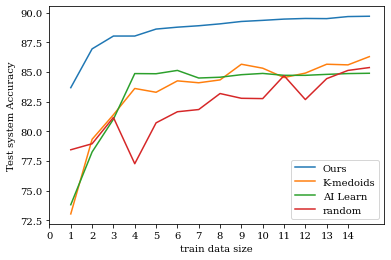

In [ ]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
avgs_rand = [np.average([scores_ours[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
stds_rand = [np.std([scores_ours[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
#plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand, yerr=stds_rand, label=f'Ours')
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand,  label=f'Ours')


avgs_rand = [np.average([scores_baseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
stds_rand = [np.std([scores_baseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
#plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand, yerr=stds_rand, label=f'K-medoids')
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand,  label=f'K-medoids')

avgs_rand = [np.average([scores_aibaseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
#stds_rand = [np.std([scores_aibaseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand,  label=f'AI Learn')


avgs_rand = [np.average([scores_random[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
stds_rand = [np.std([scores_random[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
#plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand, yerr=stds_rand, label=f'random')
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand,  label=f'random')
'''

avgs_rand = [np.average([scores_ours[triall][i] - scores_baseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
stds_rand = [np.std([scores_ours[triall][i] - scores_baseline[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand, yerr=stds_rand, label=f'difference between our approach and K-medoids')

avgs_rand = [np.average([scores_ours[triall][i] - scores_random[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
stds_rand = [np.std([scores_ours[triall][i] - scores_random[triall][i] for triall in range(max_trials)]) for i in range(max_subset_size)]
plt.errorbar(list(range(1,max_subset_size+1)),  avgs_rand, yerr=stds_rand, label=f'difference between our approach and rand')
'''

plt.xticks(np.arange(0,15, 1))
#plt.yticks(np.arange(-2, 22, 2))

plt.legend()
plt.ylabel('Test system Accuracy')
plt.xlabel('train data size')
plt.savefig("synthetic_data_cmplxity_all.pdf")
plt.show()